# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## (1) Import the data and required Libraries

In [8]:
# import the necessary libraries
import pandas as pd
import numpy as np
import math
import json
import datetime
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score

% matplotlib inline

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True, )
profile = pd.read_json('data/profile.json', orient='records', lines=True, )
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## (2) Exploration of  the data sets

#### Offers

In [4]:
#checking the first 5 values of the portfolio dataframe
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
#checking the number of rows and columns
portfolio.shape

(10, 6)

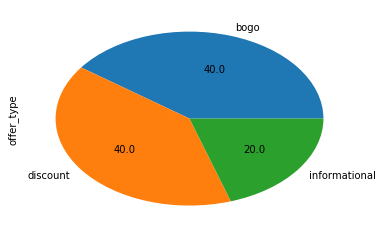

In [105]:
#checking the types of starbucks offers
portfolio.groupby('offer_type')['offer_type'].count().plot(kind='pie', autopct='%.1f')
plt.show()

80% of the offers sent to customers are discounts or buy one get on free(BOGOs).

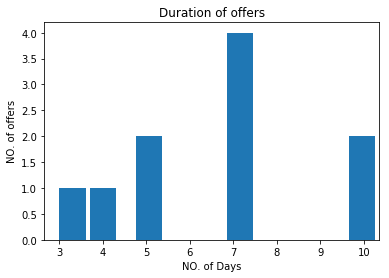

In [75]:
# plot portfolio by 'duration' 
plt.hist(portfolio.duration, width=0.6,bins=20)
plt.ylabel('NO. of offers')
plt.xlabel('NO. of Days')
plt.title('Duration of offers')
plt.xticks(range(3,11))

plt.show()

We can see that most offers run for 7 days, 3 being the lowest  and 10 being the highest number of days.

In [76]:
# print portfolio statistics
portfolio.duration.describe()

count    10.000000
mean      6.500000
std       2.321398
min       3.000000
25%       5.000000
50%       7.000000
75%       7.000000
max      10.000000
Name: duration, dtype: float64

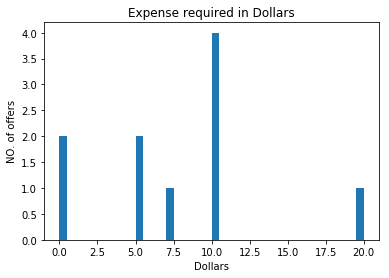

In [90]:
# plot portfolio by 'duration' 
plt.hist(portfolio.difficulty, bins=40)
plt.ylabel('NO. of offers')
plt.xlabel('Dollars')
plt.title('Expense required in Dollars')
plt.show()

Offers require a customer has to spend  between 0 dollar to 20 dollars to receive a reward, 10 dollars being the most common.

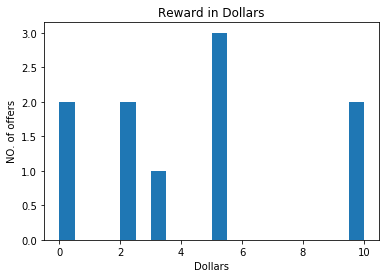

In [97]:
# plot portfolio by 'reward' 
plt.hist(portfolio.reward, bins=20)
plt.ylabel('NO. of offers')
plt.xlabel('Dollars')
plt.title('Reward in Dollars')
plt.show()

Most rewards range from 0 dollar to 10 dollars; 5 dollars  being the most common.

In [96]:
# print reward column statistics
portfolio.reward.describe()

count    10.000000
mean      4.200000
std       3.583915
min       0.000000
25%       2.000000
50%       4.000000
75%       5.000000
max      10.000000
Name: reward, dtype: float64

#### Customers demograph

In [11]:
# print the first rows of profile
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [12]:
# print the rows and columns od profile
profile.shape

(17000, 5)

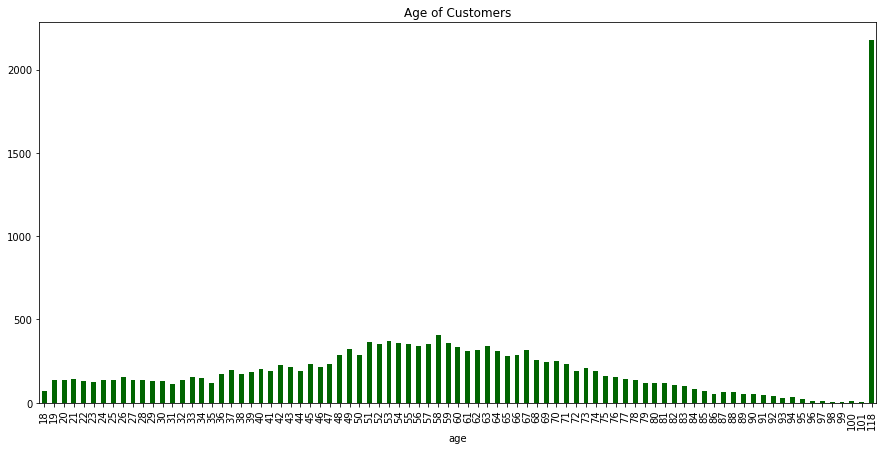

In [104]:
# sort profile by 'age' and plot
profile.groupby('age')['age'].count().plot.bar(title='Age of Customers',figsize=(15,7),color='darkgreen')
plt.show()

The age of customers seems to be some how in a normal distribution, except for the 118 years' bar which towers over all the other bars.     
This is requires further investigation

In [107]:
#creating a dataframe with a filter of customers aged 118 yrs
yrs_118 = profile[profile.age == 118]
yrs_118.head(20)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


In [108]:
#statistics of the yrs_118
yrs_118.describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


The further exploration and statistics of the members aged 118 yrs seem to be a data recording error, or perhaps these are customers who didn't want to share their data.    
This are outliers that we need to remove before training models. 

Lets filter out customers who are 118 yrs old and see.

In [109]:
#creating a dataframe with customers aged 188yrs filtered out 
age_delete_118_ = yrs_118 = profile[profile.age != 118]

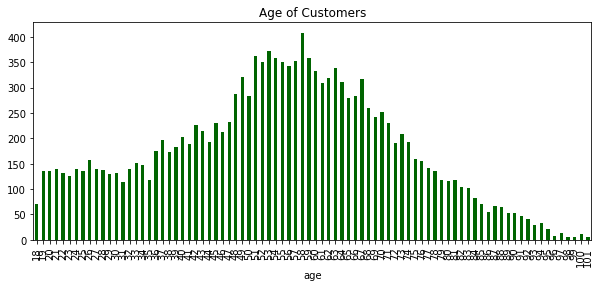

In [110]:
#sort 'age_delete_118_' by 'age' and plot
age_delete_118_.groupby('age')['age'].count().plot.bar(title='Age of Customers',figsize=(10,4),color='darkgreen')
plt.show()

As expected, the aged of customers is skewed to the left.     
Most customers are in the mid age, who we  might speculate to have a make more or say can afford the "starbucks lifetstyle". 

Lets check if our hypothesis is correct in the next graph


In [111]:
# print the 'age_delete_118_' statistics on 'age' and 'income' columns
age_delete_118_[['income','age']].describe()

,income,age
count,14825.000000,14825.000000
mean,65404.991568,54.393524
std,21598.299410,17.383705
min,30000.000000,18.000000
25%,49000.000000,42.000000
50%,64000.000000,55.000000
75%,80000.000000,66.000000
max,120000.000000,101.000000


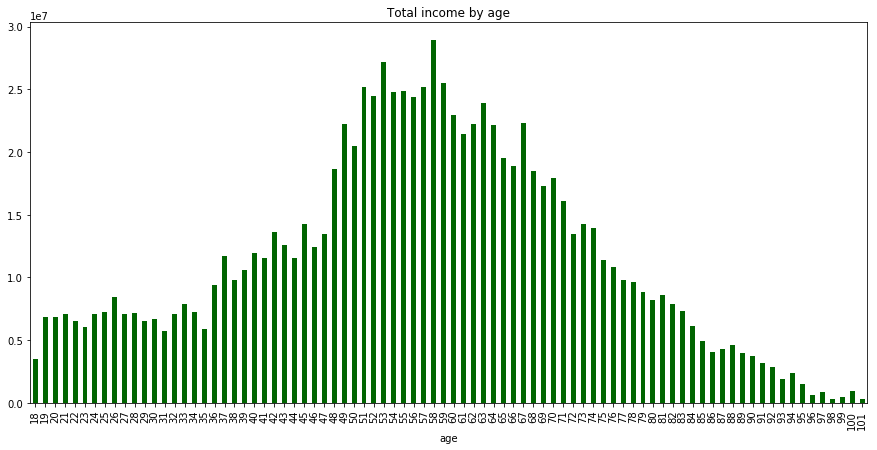

In [112]:
# sort 'age_delete_118_' by 'age' and plot the 'income' values
age_delete_118_.groupby(['age'])['income'].sum().plot.bar(title='Total income by age',figsize=(15,7),color='darkgreen')
plt.show()

The plot above shows that mid ages are the highest income earners. That confirms why they are the  most customers

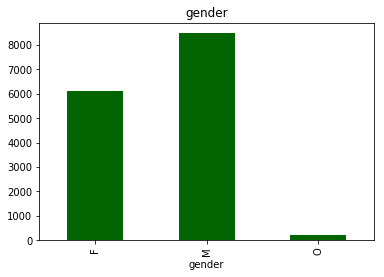

In [114]:
# sort profile by 'gender' and plot
profile.groupby('gender')['gender'].count().plot.bar(title='gender',color='darkgreen')
plt.show()

There are three groups of gender.   
Most of the customers are male.   
The least are others


In [115]:
# change the 'became_member_on' column to datetime and save as time
time = pd.to_datetime(profile.became_member_on,format='%Y%m%d')

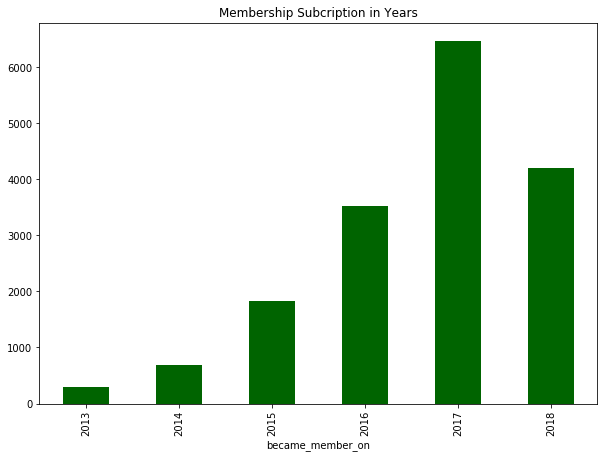

In [116]:
#sort time by 'year' and plot
time.groupby(time.dt.year).count().plot.bar(title='Membership Subcription in Years',figsize=(10,7),color='darkgreen')
plt.show()

Membership subscription begins on  the year 2013 until 2018, 2017 being the most subscribed year.

#### Members Activity

In [117]:
# print  first rows of transcript dataframe
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [118]:
transcript.shape

(306534, 4)

In [119]:
# print statistics on the time column
transcript.time.describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

The average time spent to complete a test so as to receive the offer is 366 hrs

In [120]:
# sum up the person column
transcript.groupby('person')['person'].count().sum()

306534

## (3) Cleaning data for machine learning

In [121]:
# replacing the column string values  with easiest numerical values
def map_cat_to_int(df,col):
    """
    - Takes inputs a dataframe and its specified column.
    - changes the column into category type.
    - encodes the categorical values into numerical values
    Args:
    df: dataframe
    col : dataframe column
    Returns:
    pandas_dataframe: Dataframe with numerical values 
    encoded on the specified column.
    """
    
    #change column type to category
    df[col] = df[col].astype('category')
    # replace categorical labels in 'customer_id' column with numerical labels
    df[col] = df[col].cat.codes
    
    return df

##### Profile dataframe cleaning

In [28]:
def _to_clean_df0(df):
    """
    - pre-processes the copied dataframe for use by ML model
    
    Args:
    df pandas_dataframe: original dataframe 
    Returns:
    df pandas_dataframe: processed/cleaned dataframe to be used by ML model
    """
    
    # create a copy of profile
    df_to_clean = profile.copy()
    
    # delete all rows with null values
    df_to_clean.dropna(axis=0, inplace=True)
    # rename the 'id' column to 'customer_id' 
    df_to_clean = df_to_clean.rename(columns={'id':'customer_id'})
    # sort the columns
    df_to_clean = df_to_clean.reindex(columns=['customer_id', 'age', 'became_member_on', 'gender', 'income'])
    # replace categorical labels in 'customer_id' column with numerical labels
    df_to_clean = map_cat_to_int(df_to_clean,'customer_id')
    # change the dtype of 'became_member_on' to datetime type
    df_to_clean.became_member_on = pd.to_datetime(df_to_clean.became_member_on, format='%Y%m%d', errors='ignore')
    # create a 'membership_year' column
    df_to_clean['membership_year'] = df_to_clean.became_member_on.dt.year
    # create a 'membership_month' column
    df_to_clean['membership_month'] = df_to_clean.became_member_on.dt.month
    #create a 'membership_days' column
    df_to_clean['membership_days'] = datetime.datetime.today().date() - df_to_clean['became_member_on'].dt.date
    df_to_clean['membership_days'] = df_to_clean['membership_days'].dt.days
    # replace categorical labels in 'gender' column with numerical labels
    df_to_clean = map_cat_to_int(df_to_clean,'gender')
    
    return df_to_clean

In [29]:
clean_profile = _to_clean_df0(profile)

In [30]:
clean_profile.head()

,customer_id,age,became_member_on,gender,income,membership_year,membership_month,membership_days
1,346,55,2017-07-15,0,112000.0,2017,7,1111
3,6962,75,2017-05-09,0,100000.0,2017,5,1178
5,13107,68,2018-04-26,1,70000.0,2018,4,826
8,3246,65,2018-02-09,1,53000.0,2018,2,902
12,2669,58,2017-11-11,1,51000.0,2017,11,992


#### Transcipt dataframe cleaning

###### event column preprocessing
Two important points to keep in mind:
1. Since we are interested in the events related with the offers, i.e offer received, offer viewed, offer completed, we will remove all events of 'transaction' because they are not directly related with offers.
2. we will exclude all the events of 'offer recieved',since I want to focus on whether the customer:
Only viewed the offer (offer viewed)
viewed the offer and then completed it (offer viewed)&(offer completed).

In [31]:
def _to_clean_df1(df):
    """
    - pre-processes the copied dataframe for use by ML model
    
    Args:
    df pandas_dataframe: original dataframe 
    Returns:
    df pandas_dataframe: processed/cleaned dataframe to be used by ML model
    """ 
    
    df_to_clean = transcript.copy()
    
    # renaming 'person' column to 'customer_id'
    df_to_clean = df_to_clean.rename(columns={'person':'customer_id'})
    
    df_to_clean = df_to_clean.reindex(columns=['customer_id','event','time','value'])
    
    # replace categorical labels in 'customer_id' column with numerical labels
    df_to_clean = map_cat_to_int(df_to_clean,'customer_id')
    
    keys = list(set(key for dic in df_to_clean.value for key in dic.keys())) 
    
    #create columns and specify the datatype of each of them
    df_to_clean['offer_id'] = '' # datatype : string
    df_to_clean['amount'] = 0  # datatype : integer
    df_to_clean['reward'] = 0  # datatype : integer
    
    # then updating it and using the values to fill in the columns created above
    for idx, row in df_to_clean.iterrows():
        for k in row['value']:
            if k == 'offer_id' or k == 'offer id': # b/c 'offer_id' and 'offer id' are representing the same thing 
                df_to_clean.at[idx, 'offer_id'] = row['value'][k]
            if k == 'amount':
                df_to_clean.at[idx, 'amount'] = row['value'][k]
            if k == 'reward':
                df_to_clean.at[idx, 'reward'] = row['value'][k]
                
    # filling all the NaNs in the 'offer_id' column with 'N/A' values (i.e. Not Applicable)
    df_to_clean['offer_id'] = df_to_clean['offer_id'].apply(lambda x: 'N/A' if x == '' else x)
    
    # excluding all events of 'transaction' from our df_to_clean dataset
    df_to_clean = df_to_clean[df_to_clean['event'] != 'transaction']

    # excluding all events of 'offer received' 
    df_to_clean = df_to_clean[df_to_clean['event'] != 'offer received']
    
    # replacing the 'event' categorical labels with coressponding numerical label
    df_to_clean = map_cat_to_int(df_to_clean,'event')
    
    # replacing the categorical values in the 'offer_id' column by its corresponding numerical values
    df_to_clean = map_cat_to_int(df_to_clean,'offer_id')
    
    # dropping the 'value' column 
    df_to_clean.drop('value', axis=1, inplace=True)
    
    return df_to_clean


In [32]:
clean_transcript = _to_clean_df1(transcript)

In [33]:
clean_transcript.head()

,customer_id,event,time,offer_id,amount,reward
12650,3728,1,0,8,0,0
12651,13994,1,0,5,0,0
12652,1051,1,0,4,0,0
12653,169,1,0,7,0,0
12655,12743,1,0,5,0,0


##### cleaning portfolio dataframe

In [34]:
def _to_clean_df2(df):
    """
    - pre-processes the copied dataframe for use by ML model
    
    Args:
    df pandas_dataframe: original dataframe 
    Returns:
    df pandas_dataframe: processed/cleaned dataframe to be used by ML model
    """
    #create a copy of portfolio
    df_to_clean = portfolio.copy()
    # rename the 'id' column to 'offer_id' 
    df_to_clean= df_to_clean.rename(columns={'id':'offer_id'})
    #sort the columns
    df_to_clean = df_to_clean.reindex(columns=['offer_id','offer_type','difficulty','reward','duration','channels'])
    
    # replacing the 'customer_id' string values  with easiest numerical values
    df_to_clean = map_cat_to_int(df_to_clean,'offer_id')
    df_to_clean = map_cat_to_int(df_to_clean,'offer_type')
    
    # creating dummy variables from the 'channels' column 
    df_to_clean['channel_email'] = df_to_clean['channels'].apply(lambda x: 1 if 'email' in x else 0)
    df_to_clean['channel_mobile'] = df_to_clean['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    df_to_clean['channel_social'] = df_to_clean['channels'].apply(lambda x: 1 if 'social' in x else 0)
    df_to_clean['channel_web'] = df_to_clean['channels'].apply(lambda x: 1 if 'web' in x else 0)
    
    # checking that the dummy variables are correctly created 
    df_to_clean[['channel_email','channel_mobile','channel_web','channel_social']].head()
    
    # dropping the 'channels' column
    df_to_clean.drop('channels', axis=1, inplace=True)
    # Initialize a scaler, then apply it to the features
    scaler = MinMaxScaler() # default=(0, 1)
    numerical = ['difficulty','reward']

    #features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
    df_to_clean[numerical] = scaler.fit_transform(df_to_clean[numerical])
    
    return df_to_clean

In [35]:
clean_portfolio = _to_clean_df2(portfolio)

In [36]:
clean_portfolio.head()

,offer_id,offer_type,difficulty,reward,duration,channel_email,channel_mobile,channel_social,channel_web
0,7,0,0.50,1.0,7,1,1,1,0
1,4,0,0.50,1.0,5,1,1,1,1
2,3,2,0.00,0.0,4,1,1,0,1
3,6,0,0.25,0.5,7,1,1,0,1
4,0,1,1.00,0.5,10,1,0,0,1


##### Merging the three clean datasets (Portfolio, Profile and Transcript ) into ONE Combined Clean Dataset

In [37]:
def merge_dfs(df1,df2,df3):
    """
    - Takes inputs as three dataframes.
    - Merges them into a single dataframe
    Args:
    df1,df2,df3: respective dataframes to be merged
    Returns:
    merged_df pandas_dataframe: Dataframe obtained from merging the 
    3 dataframes
    """
    
    # merge 'clean_transcript' dataset with 'clean_portfolio' on 'offer_id'
    combined_df =clean_transcript.merge(clean_portfolio,how='left',on='offer_id')
    
    # join 'combined_df' dataset with 'clean_profile' on 'customer_id'
    combined_df = combined_df.merge(clean_profile,how ='left', on = 'customer_id')
    
    combined_df.dropna(inplace=True, axis=0)
    
    return combined_df

In [38]:
# merge the dataframes
combined_df = merge_dfs(clean_transcript,clean_portfolio,clean_transcript)

In [39]:
# print the first rows of combined_df
combined_df.head()

,customer_id,event,time,offer_id,amount,reward_x,offer_type,difficulty,reward_y,duration,...,channel_mobile,channel_social,channel_web,age,became_member_on,gender,income,membership_year,membership_month,membership_days
0,3728,1,0,8,0,0,0,0.25,0.5,5,...,1,1,1,49.0,2017-09-30,0.0,56000.0,2017.0,9.0,1034.0
1,13994,1,0,5,0,0,2,0.00,0.0,3,...,1,1,0,18.0,2018-05-05,1.0,37000.0,2018.0,5.0,817.0
2,1051,1,0,4,0,0,0,0.50,1.0,5,...,1,1,1,61.0,2016-07-18,1.0,96000.0,2016.0,7.0,1473.0
3,169,1,0,7,0,0,0,0.50,1.0,7,...,1,1,0,21.0,2016-11-24,0.0,74000.0,2016.0,11.0,1344.0
4,12743,1,0,5,0,0,2,0.00,0.0,3,...,1,1,0,59.0,2016-08-04,1.0,34000.0,2016.0,8.0,1456.0


In [40]:
# print the null values of combined_df 
print(combined_df.isnull().sum()/combined_df.shape[0]*100)

customer_id         0.0
event               0.0
time                0.0
offer_id            0.0
amount              0.0
reward_x            0.0
offer_type          0.0
difficulty          0.0
reward_y            0.0
duration            0.0
channel_email       0.0
channel_mobile      0.0
channel_social      0.0
channel_web         0.0
age                 0.0
became_member_on    0.0
gender              0.0
income              0.0
membership_year     0.0
membership_month    0.0
membership_days     0.0
dtype: float64


In [41]:
# print the details of combined_df
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79461 entries, 0 to 91303
Data columns (total 21 columns):
customer_id         79461 non-null int16
event               79461 non-null int8
time                79461 non-null int64
offer_id            79461 non-null int8
amount              79461 non-null int64
reward_x            79461 non-null int64
offer_type          79461 non-null int8
difficulty          79461 non-null float64
reward_y            79461 non-null float64
duration            79461 non-null int64
channel_email       79461 non-null int64
channel_mobile      79461 non-null int64
channel_social      79461 non-null int64
channel_web         79461 non-null int64
age                 79461 non-null float64
became_member_on    79461 non-null datetime64[ns]
gender              79461 non-null float64
income              79461 non-null float64
membership_year     79461 non-null float64
membership_month    79461 non-null float64
membership_days     79461 non-null float64
dtypes: 

In [42]:
# print the columns of combined_df
combined_df.columns

Index(['customer_id', 'event', 'time', 'offer_id', 'amount', 'reward_x',
       'offer_type', 'difficulty', 'reward_y', 'duration', 'channel_email',
       'channel_mobile', 'channel_social', 'channel_web', 'age',
       'became_member_on', 'gender', 'income', 'membership_year',
       'membership_month', 'membership_days'],
      dtype='object')

In [43]:
finished_tests  = combined_df[combined_df.event == 1]

In [44]:
# sum the values of the columns
finished_tests[['channel_mobile','channel_social','channel_web']].sum().sort_values(ascending=False)

channel_mobile    47993
channel_web       38636
channel_social    37227
dtype: int64

In [45]:
# calculate the percentage of completed tests
finished_tests.customer_id.count()/combined_df.shape[0]

0.6334679905865771

In [46]:
# print the number of row and column
combined_df.shape

(79461, 21)

In [47]:
# print the first 5 rows of combined_df
combined_df.head()

,customer_id,event,time,offer_id,amount,reward_x,offer_type,difficulty,reward_y,duration,...,channel_mobile,channel_social,channel_web,age,became_member_on,gender,income,membership_year,membership_month,membership_days
0,3728,1,0,8,0,0,0,0.25,0.5,5,...,1,1,1,49.0,2017-09-30,0.0,56000.0,2017.0,9.0,1034.0
1,13994,1,0,5,0,0,2,0.00,0.0,3,...,1,1,0,18.0,2018-05-05,1.0,37000.0,2018.0,5.0,817.0
2,1051,1,0,4,0,0,0,0.50,1.0,5,...,1,1,1,61.0,2016-07-18,1.0,96000.0,2016.0,7.0,1473.0
3,169,1,0,7,0,0,0,0.50,1.0,7,...,1,1,0,21.0,2016-11-24,0.0,74000.0,2016.0,11.0,1344.0
4,12743,1,0,5,0,0,2,0.00,0.0,3,...,1,1,0,59.0,2016-08-04,1.0,34000.0,2016.0,8.0,1456.0


In [48]:
#print the unique values of amount column
combined_df.amount.unique()

array([0])

## (4) Modelling

Now, it is the time to build the model that can help us in predicting HOW will a given customer respond to an offer?

In [49]:
combined_df.columns

Index(['customer_id', 'event', 'time', 'offer_id', 'amount', 'reward_x',
       'offer_type', 'difficulty', 'reward_y', 'duration', 'channel_email',
       'channel_mobile', 'channel_social', 'channel_web', 'age',
       'became_member_on', 'gender', 'income', 'membership_year',
       'membership_month', 'membership_days'],
      dtype='object')

But first, We need to split data into features and target labels, considering ONLY those features that we believe are important for our model to predict accurately.

Those features are as follows:

- time_h
- offer_id
- amount
- reward_x ( Will be renamed to 'reward')
- difficulty
- duration_h
- offer_type
- gender
- age_group
- income_range
- member_type  

**Our target is:**  

'event' that will be either:  
- 1 : offer completed
- 2 : offer viewed

In [50]:
# Rename 'reward_x' column to 'reward'
combined_df.rename(columns ={'reward_x':'reward'}, inplace = True)

In [51]:
# print the unique values of time column
combined_df.time.unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714])

In [52]:
# Split the data into features and target label
X = combined_df[['offer_id', 'time', 'amount', 'reward',
       'offer_type', 'difficulty', 'duration', 'channel_email',
       'channel_mobile', 'channel_social', 'channel_web', 'age',
        'gender', 'income', 'membership_year',
       'membership_month', 'membership_days']]
Y = combined_df['event']

In [53]:
# print the first five rows of X
X.head()

,offer_id,time,amount,reward,offer_type,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,age,gender,income,membership_year,membership_month,membership_days
0,8,0,0,0,0,0.25,5,1,1,1,1,49.0,0.0,56000.0,2017.0,9.0,1034.0
1,5,0,0,0,2,0.00,3,1,1,1,0,18.0,1.0,37000.0,2018.0,5.0,817.0
2,4,0,0,0,0,0.50,5,1,1,1,1,61.0,1.0,96000.0,2016.0,7.0,1473.0
3,7,0,0,0,0,0.50,7,1,1,1,0,21.0,0.0,74000.0,2016.0,11.0,1344.0
4,5,0,0,0,2,0.00,3,1,1,1,0,59.0,1.0,34000.0,2016.0,8.0,1456.0


In [54]:
# print the unique values in the amount column
X.amount.unique()

array([0])

In [55]:
# print the first five rows of Y
Y.head()

0    1
1    1
2    1
3    1
4    1
Name: event, dtype: int8

In [56]:
# Initailize the scaler
scaler = MinMaxScaler()
# Define the columns to be scaled
features = ['time', 'amount', 'reward', 'duration','age','income','membership_month','membership_days']
# Create a copy of X
X_scaled = X.copy()
# transform the columns values with the scaler
X_scaled[features] = scaler.fit_transform(X_scaled[features])
# print the first five rows of X_scaled
X_scaled.head()

,offer_id,time,amount,reward,offer_type,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,age,gender,income,membership_year,membership_month,membership_days
0,8,0.0,0.0,0.0,0,0.25,0.285714,1,1,1,1,0.373494,0.0,0.288889,2017.0,0.727273,0.164015
1,5,0.0,0.0,0.0,2,0.00,0.000000,1,1,1,0,0.000000,1.0,0.077778,2018.0,0.363636,0.044981
2,4,0.0,0.0,0.0,0,0.50,0.285714,1,1,1,1,0.518072,1.0,0.733333,2016.0,0.545455,0.404827
3,7,0.0,0.0,0.0,0,0.50,0.571429,1,1,1,0,0.036145,0.0,0.488889,2016.0,0.909091,0.334065
4,5,0.0,0.0,0.0,2,0.00,0.000000,1,1,1,0,0.493976,1.0,0.044444,2016.0,0.636364,0.395502


In [57]:
X_scaled.dtypes

offer_id               int8
time                float64
amount              float64
reward              float64
offer_type             int8
difficulty          float64
duration            float64
channel_email         int64
channel_mobile        int64
channel_social        int64
channel_web           int64
age                 float64
gender              float64
income              float64
membership_year     float64
membership_month    float64
membership_days     float64
dtype: object

In [61]:
# creating training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, random_state=42)

In [62]:
X_train.shape

(59595, 17)

In [63]:
y_train.shape

(59595,)

In [64]:
X_test.shape

(19866, 17)

In [65]:
y_test.shape

(19866,)

In order to evaluate our models performance , we will use F1-score. This Metric was chosen for the following reasons :

Since we have a simple binary classification problem, i.e. either : offer viewed or offer completed. F1-score considers both the precision p and the recall r of the test to compute the score: p is the number of correct positive results divided by the number of all positive results returned by the classifier.

In [66]:
# defining a function to calculate the accuracy for the models we will try below 
def predict_score(model):
    """
    - Takes inputs as trained model
    - use the model to predict the correct labels.
    - prints out the models F1_score
    Args:
    model: trained model
    
    prints:
    F1_score of the model
    """
    pred = model.predict(X_test)
    
    # Calculate the absolute errors
    score = f1_score(pred, y_test)
    
    return score

For Now, several models will be tried , then the best model along them would be chosen. Followed by an implementation for a GridSearch to find the best parameters ( in order to improve the performance of the chosen model)



1. **Decision Tree**

In [67]:
# Initailize the DecissionTreeClassifier, then train and print the scores
dtree = DecisionTreeClassifier()

dtree.fit(X_train, y_train)
print(f'Accuracy of Decision Tree classifier on training set: {round(dtree.score(X_train, y_train)*100,2)}%.')
print(f'F1_score: {predict_score(dtree)}')

Accuracy of Decision Tree classifier on training set: 100.0%.
F1_score: 1.0



2. **Naive Bayes**

In [68]:
# Initailize the GaussianNaiveBaye, then train and print the scores
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
print(f'Accuracy of SVM classifier on training set: {round(gnb.score(X_train, y_train)*100,2)}%.')
print(f'F1_score: {predict_score(gnb)}')

Accuracy of SVM classifier on training set: 100.0%.
F1_score: 1.0


3. **Random Forest**

In [70]:
# Initailize the RandomForestRegressor, then train and print the scores
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

rf.fit(X_train, y_train)
print(f'Accuracy of RAndom Forest classifier on training set: {round(rf.score(X_train, y_train)*100,2)}%.')
print(f'F1_score: {predict_score(rf)}')

Accuracy of RAndom Forest classifier on training set: 100.0%.
F1_score: 1.0


4. **K-Nearest Neighbors**

In [71]:
# Initailize the KNearestNeighbors, then train and print the scores
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
print(f'Accuracy of K-NN classifier on training set: {round(knn.score(X_train, y_train)*100,2)}%.')
print(f'F1_score: {predict_score(knn)}')

Accuracy of K-NN classifier on training set: 99.7%.
F1_score: 0.9934794563594942


4. **LogisticRegression**

In [72]:
# Initailize the LogisticRegression, then train and print the scores
logreg = LogisticRegression()

logreg.fit(X_train, y_train)
print(f'Accuracy of Logistic regression classifier on training set: {round(logreg.score(X_train, y_train)*100,2)}%.')
print(f'F1_score: {predict_score(logreg)}%')

Accuracy of Logistic regression classifier on training set: 100.0%.
F1_score: 1.0%


5. **Support Vector Machine**

In [73]:
# Initailize the SVM, then train and print the scores
svmlin = svm.LinearSVC()

svmlin.fit(X_train, y_train)
print(f'Accuracy of SVM classifier on training set: {round(svmlin.score(X_train, y_train)*100,2)}%.')
print(f'F1_score: {predict_score(svmlin)}')

Accuracy of SVM classifier on training set: 82.55%.
F1_score: 0.881295962258915


### Model Evaluation

In [74]:
# creating the variables that will be used to fill the results table
models = [svmlin, dtree, gnb, knn, rf, logreg]
model_names = [type(n).__name__ for n in models]
training_accuracy = [x.score(X_train, y_train)*100 for x in models]
predection_accuracy = [predict_score(y) for y in models]

In [75]:
# structuring a table to view the results of the different model tried above
results = [training_accuracy, predection_accuracy]
results_df = pd.DataFrame(results, columns = model_names, index=['Training Accuracy', 'Predicting F1_score'])

In [76]:
# show the results dataframe 
results_df

,LinearSVC,DecisionTreeClassifier,GaussianNB,KNeighborsClassifier,RandomForestRegressor,LogisticRegression
Training Accuracy,82.552228,100.0,100.0,99.701317,100.0,100.0
Predicting F1_score,0.881296,1.0,1.0,0.993479,1.0,1.0


The above table, shows the F1_score related with using different models of supervised learning. As presented on the table, we had 100% accuracy in both training and testing sets for 4 models ( out of 6). I will choose any model that gave me the 100% accuracy score on the testing set. Since they did well without a lot of data munging.

### (5) Model Refinement

4 of the models had a F1-score of 1 on the test data.
2 models, the linearSVC and KNN had F1-scores of 0.88 and 0.99 respectively.  

Model improvement is not required since we have 4 high scoring models.

However, we can train Ensemble algorithm with the 4 models to reduce overfitting if the models doesn’t perform as expected on future data.

### (6) Conclusion

**A summary of the analysis on the datasets allowed me to get the following insights:**

- 80% of the offers sent to customers are Discounts and BOGOs.
- Most of the offers run for 7 days, 3 days being the lowest and 10 days being the highest.
- Offers require a customer to spend between 0 dollar to 20 dollars for them to receive a reward, and 10 dollars being the most common.
- Most rewards range from 0 dollar to 10 dollars; 5 dollars being the most common.
- Customers age range is between 18 and 101, most being in their mid-age(50s,60s).
- Most customers are in their mid-ages, make more than the younger and older customers.
- Customers income ranges from 30,000 and 120,000 with most of the customers’ incomes fall between 50,000 and 75,0000.
- There are 3 groups of gender Male,Female, and Others.
- The average time spent to complete an offer is 366 hrs or 15.25 days.
- Membership subscription begins from 2013 to 2018; 2017 being the highest subscribed year.
- Females completed around 75% of the offers they viewed, it is 16% more than males who just completed 58% of the offers they viewed. Females seems to be convinced by the promotion more than males.
